## Advanced Lane Finding Project

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

In [109]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import cv2
%matplotlib inline
import pickle
import glob

In [119]:
# Image Plot helper function
def plot_img(img, transformed_img, method_name, gray=False, original_gray=False):
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
    f.tight_layout()
    if original_gray:
        ax1.imshow(img,cmap='gray')
    else:
        ax1.imshow(img)
    ax1.set_title('Original Image', fontsize=35)
    if gray:
        ax2.imshow(transformed_img, cmap='gray')
    else:
        ax2.imshow(transformed_img)
    ax2.set_title(method_name, fontsize=35)
    plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

### Step 1: Compute the camera calibration matrix and distortion coefficients given a set of chessboard images
- Prepare the objpoints and imgpoints needed for camera calibration
- Calculate camera matrices (mtx) and distortion coefficients (dist). Mtx and dist are needed to transform 3D image into 2D image.
- Test:  correct distortion using camera matrices and distortion coefficients.

In [111]:
# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# Make a list of calibration images
images = glob.glob('camera_cal/calibration*.jpg')

# Step through the list and search for chessboard corners
for fname in images:
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (9,6),None)

    # If found, add object points, image points
    if ret == True:        
        objpoints.append(objp)
        imgpoints.append(corners)

        # Draw and display the corners
        img = cv2.drawChessboardCorners(img, (9,6), corners, ret)
        cv2.imshow('img',img)
        cv2.waitKey(500)
        
    else:
        print("This image did not process: ", fname)

#cv2.destroyAllWindows()

This image did not process:  camera_cal\calibration1.jpg
This image did not process:  camera_cal\calibration4.jpg
This image did not process:  camera_cal\calibration5.jpg


**[Note]: Three images did not process !!!!!!**

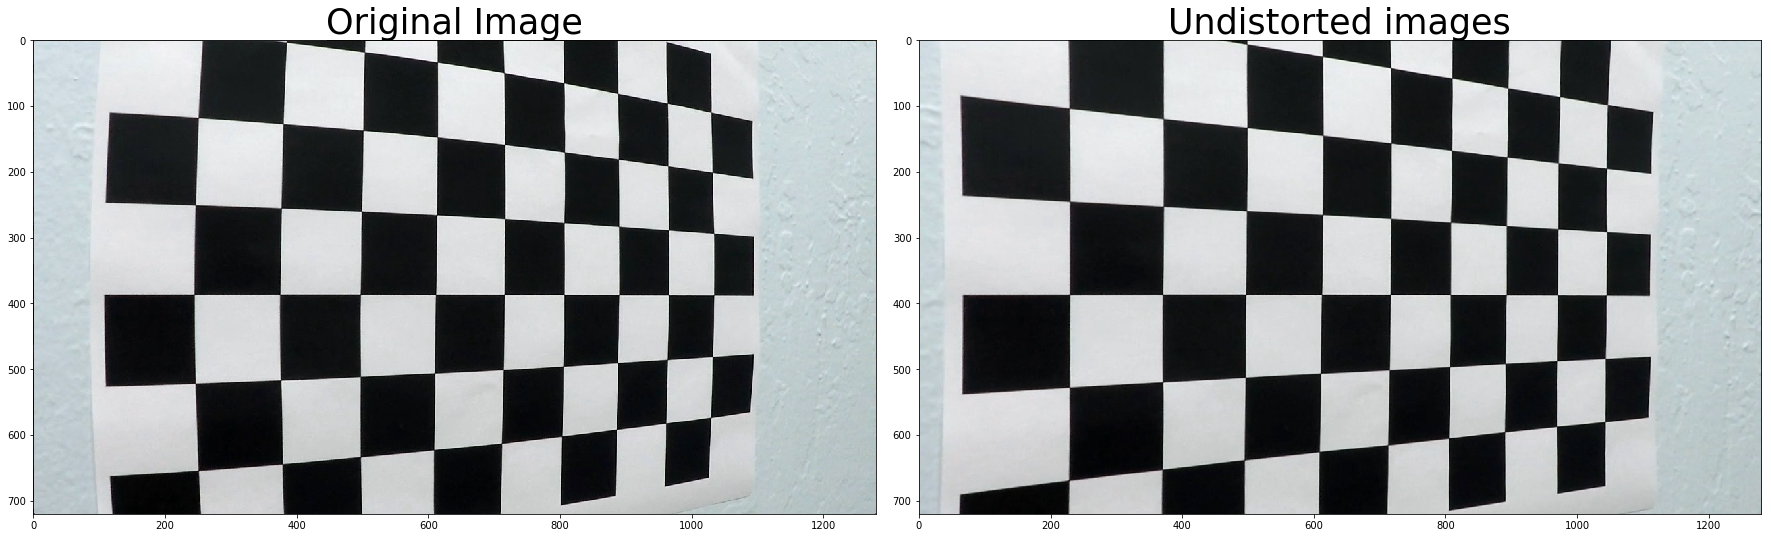

In [121]:
img = cv2.imread('camera_cal/calibration5.jpg')
img_size = (img.shape[1], img.shape[0])

# Do camera calibration given object points and image points
# get cameraMatrix and distortionCoefficient
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size,None,None)

# Save the camera calibration result for later use: cameraMatrix and distortion coefficient
dist_pickle = {}
dist_pickle["mtx"] = mtx
dist_pickle["dist"] = dist
pickle.dump( dist_pickle, open( "assets/mtx_dist_pickle.p", "wb" ) )

# correct distortion
undistorted = cv2.undistort(img, mtx, dist, None, mtx)

# save the transformed image
# cv2.imwrite('assets/undistorted.jpg',undistorted)

# Visualize undistortion
plot_img(img, undistorted, 'Undistorted images')

#### Let's test on a road image
- mtx, dist
- cv2.undistort

In [123]:
# Read in the saved cameraMatrix and distortion coefficient
dist_pickle = pickle.load(open("assets/mtx_dist_pickle.p", "rb"))
mtx = dist_pickle["mtx"]
dist = dist_pickle["dist"]

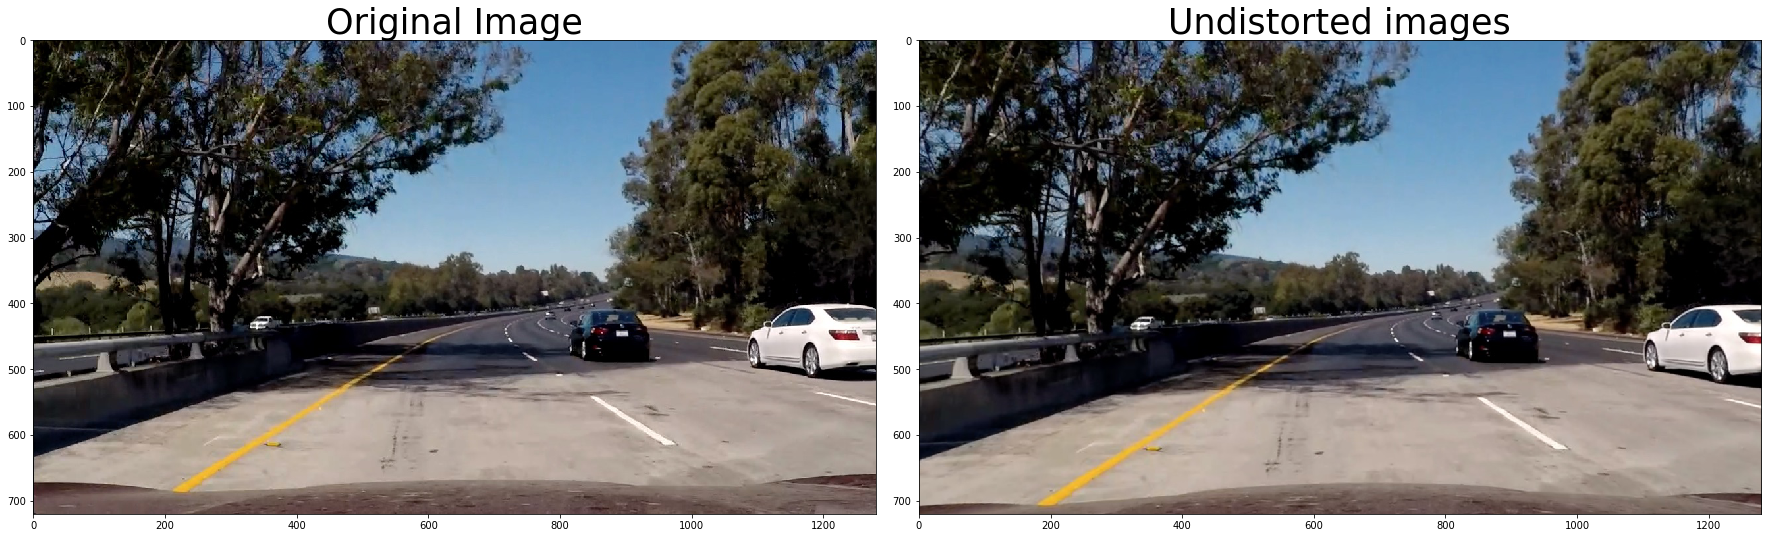

In [124]:
img = mpimg.imread('test_images/test5.jpg')
# correct distortion
undistorted = cv2.undistort(img, mtx, dist, None, mtx)
# Visualize undistortion
plot_img(img, undistorted, 'Undistorted images')

### Step 2: Thresholding 
- Input: undistorted image
- Convert RGB into HLS:
- Apply L channel threshold using Sobel X
- Apply S channel threshold
- Combine two binaries

In [125]:
def thresholding(img, sx_thresh=(20, 100), s_thresh=(170, 255)):   
    # Convert to HLS color space and separate the S channel and L channel
    #hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HSV).astype(np.float)
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS) # has to add [.astype(np.float)], it shows dark image other then.
    l_channel = hls[:,:,1] 
    s_channel = hls[:,:,2]
    # Sobel x
    sobelx = cv2.Sobel(l_channel, cv2.CV_64F, 1, 0) # Take the derivative in x
    abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
    
    # Threshold x gradient
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= sx_thresh[0]) & (scaled_sobel <= sx_thresh[1])] = 1
    
    # Threshold color channel
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh[0]) & (s_channel <= s_thresh[1])] = 1
    
    # Combine   
    combine = np.zeros_like(sxbinary)
    combine[(sxbinary==1) | (s_binary==1)] = 1
    
    return combine

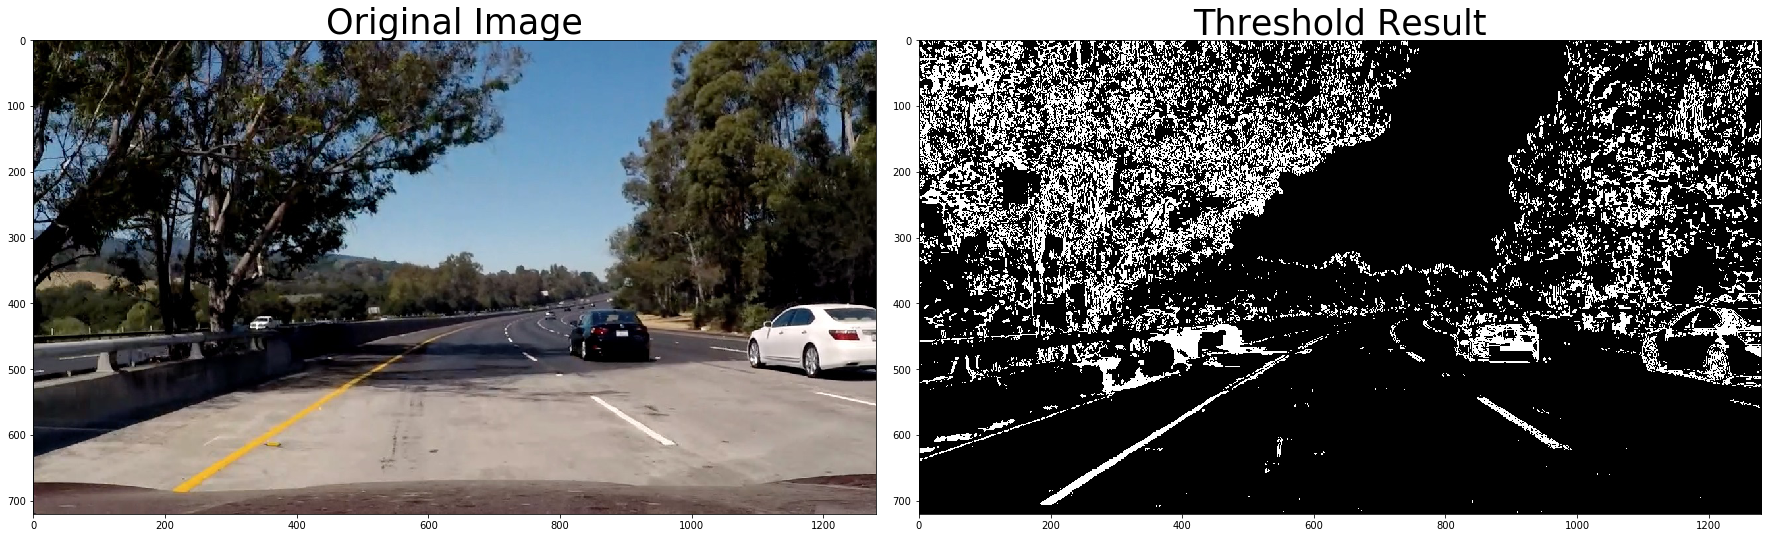

In [127]:
threshold = thresholding(undistorted)
plot_img(img,threshold, 'Threshold Result', gray=True)

### Step 3: Perspective Transformation 
- Input: a binary image after thresholding step, Source points and Destination points
- Approximate 4 Source points: a image with straight lines is easier to work on in the beginning.
- Make 4 Destination points based on 4 Source points

In [132]:
# Choose offset from image corners to plot detected corners
# This should be chosen to present the result at the proper aspect ratio
# Grab the image shape
img_size = (img.shape[1], img.shape[0])
centerX = img_size[0]//2
top_offset = 100
bottom_offset = 480

# For source points I'm grabbing the outer four detected corners
src = np.float32([(centerX-top_offset, 480),
                  (centerX+top_offset, 480),
                  (centerX+bottom_offset,img_size[1]),
                  (centerX-bottom_offset,img_size[1])])
# For destination points, I'm arbitrarily choosing some points to be
dst = np.float32([(centerX-bottom_offset, 0),
                  (centerX+bottom_offset, 0),
                  (centerX+bottom_offset,img_size[1]),
                  (centerX-bottom_offset,img_size[1])])

In [140]:
print(src)
print(dst)

[[  540.   480.]
 [  740.   480.]
 [ 1120.   720.]
 [  160.   720.]]
[[  160.     0.]
 [ 1120.     0.]
 [ 1120.   720.]
 [  160.   720.]]


In [133]:
def perspective_transform(img,src,dst):
    # Given src and dst points, calculate the perspective transform matrix
    M = cv2.getPerspectiveTransform(src, dst)
    Minv = cv2.getPerspectiveTransform(dst, src)
    # Warp the image using OpenCV warpPerspective()
    binary_warped = cv2.warpPerspective(img, M, (img.shape[1], img.shape[0]))

    # Return the resulting image and matrix
    return binary_warped, M, Minv

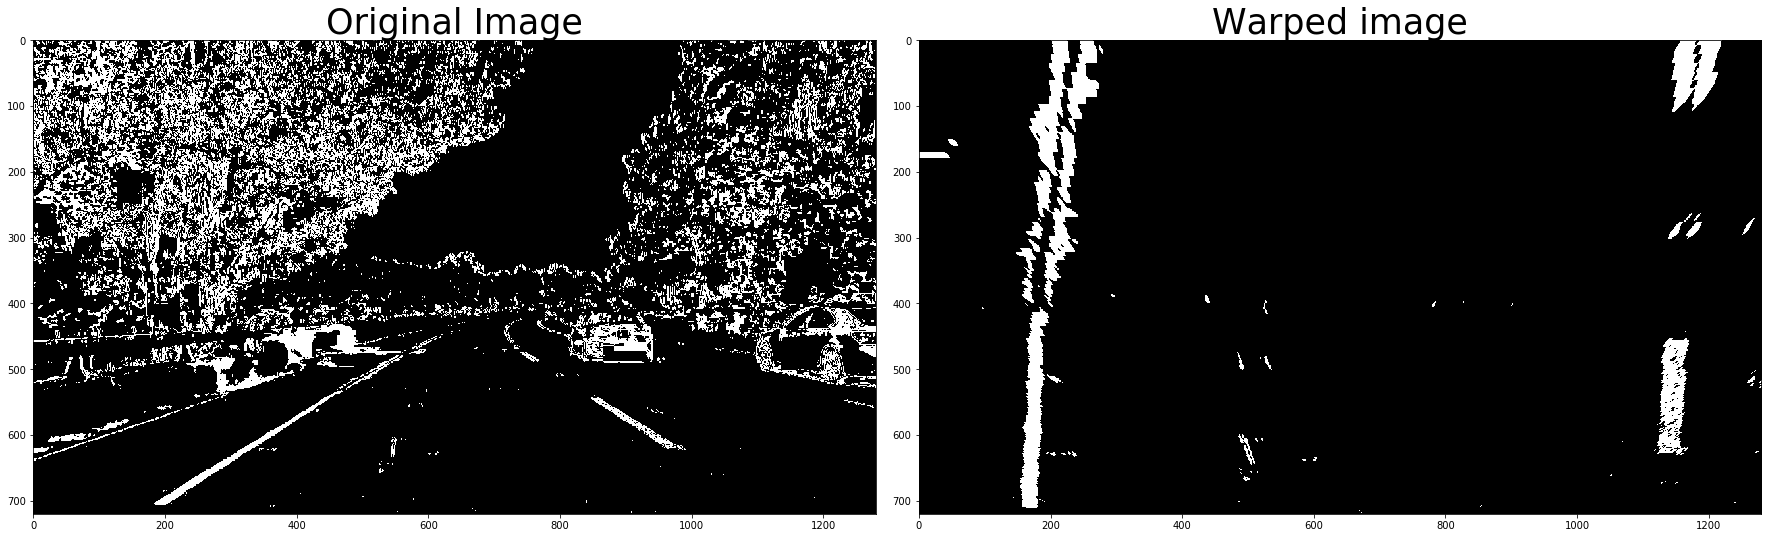

In [135]:
# Threshold image from Step 2
binary_warped, _, _ = perspective_transform(threshold,src,dst)
plot_img(threshold,binary_warped, 'Warped image', gray=True, original_gray=True)

#### Visualize source points

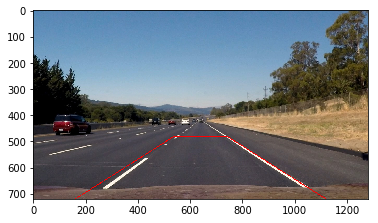

In [127]:
img = mpimg.imread('test_images/straight_lines2.jpg')
centerX = img_size[0]//2
top_offset = 100 
bottom_offset = 480

points = [(centerX-top_offset, 480),
            (centerX+top_offset, 480),
            (centerX+bottom_offset,img_size[1]),
            (centerX-bottom_offset,img_size[1])]

img2 = np.copy(img)
for i in range(len(points)):
        cv2.line(img2, points[i-1], points[i], [255, 0, 0], 2)
plt.imshow(img2)

#### Save the warped binary image
- save as png.

In [31]:
cv2.imwrite('assets/warped_binary.png', binary_warped)

True

### Step 4: Finding the lanes  - peaks in a histogram 
- Input: binary image generated in Step 3.
- Identify Right and Left line by histogram 
- Apply Sliding window method to find the best fit lines

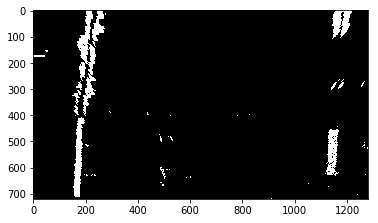

In [51]:
plt.imshow(binary_warped, cmap='gray')

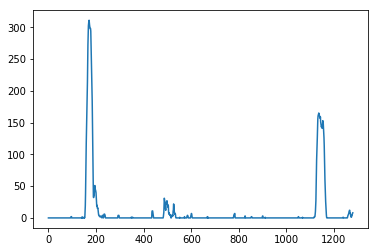

In [52]:
histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
plt.plot(histogram)
#plt.imshow(warp, cmap='gray')

In [141]:
def find_lane(binary_warped):
    ########## Finding the lanes ##############################
    # Assuming you have created a warped binary image called "binary_warped"
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
    # Create an output image to draw on and  visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint
    
    # Choose the number of sliding windows
    nwindows = 9
    # Set height of windows
    window_height = np.int(binary_warped.shape[0]/nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 2) 
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 
    
    # color the lane: left lane - RED, right lane - BLUE
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]    # RED
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]  # BLUE

    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    # get the x and y values for the fit lines
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]    
    
    return left_fit,right_fit,  ploty,left_fitx,right_fitx,  lefty,leftx,righty,rightx,  out_img

(720, 0)

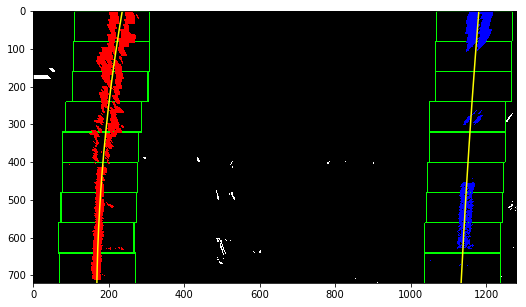

In [142]:
left_fit, right_fit, y,left_fitx, right_fitx, lefty,leftx,righty,rightx, out_img  = find_lane(binary_warped)

fig, ax = plt.subplots(figsize=(15, 5))
ax.imshow(out_img)
#plt.imshow(out_img)
plt.plot(left_fitx, y, color='yellow')
plt.plot(right_fitx, y, color='yellow')
plt.xlim(0, 1280)
plt.ylim(720, 0)

### Step 5: Mesuring Curvature
- Input: detected line pixels value x,y | bottom point y value
- Calculate Radious of a Curve f(y) = Ay^2 + By + C : see **[The Formula](http://www.intmath.com/applications-differentiation/8-radius-curvature.php)**
- Radius for left and right line
- Convert from pixel space to real work space which meter

In [144]:
def calc_curvature(pts_y, pts_x, y_eval):
    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension    
    
    # Fit a new polynomial to world-space (in meters)
    fit = np.polyfit(pts_y*ym_per_pix, pts_x*xm_per_pix, 2)
    # Calculate the curvature
    curvature = ((1 + (2*fit[0]*(y_eval*ym_per_pix) + fit[1])**2)**1.5) / np.absolute(2*fit[0])
    
    return curvature

In [145]:
left_curvature = calc_curvature(lefty, leftx, np.max(ploty))
right_curvature = calc_curvature(righty, rightx, np.max(ploty))
left_curvature,right_curvature

(1526.547485736741, 7923.8042204735766)

### Step 6: Calculate Offset - position of the vehicle
- Input: bottom 2 points fit line points X values, image X midpoint

In [146]:
def calc_offset(left_x, right_x, img_center_x):
    lane_width = abs(left_x - right_x)
    lane_center_x = (left_x + right_x)//2
    pix_offset = img_center_x - lane_center_x
    
    lane_width_m = 3.7  # How wide we expect the lane to be in meters
    return lane_width_m * (pix_offset/lane_width)

In [147]:
centerX = img.shape[1]//2 
offset = calc_offset(left_fitx[-1],right_fitx[-1], centerX )
offset

-0.04217916793277534

### Step 7: Drawing on image
- Input: original image, warped binary, best fit points x/y, Minv, left_curvature,right_curvature, offset
- Draw detected lane on the image
- Draw curvature value on the image
- Draw Offset value on the image

In [148]:
def map_lane(img, binary_warped, ploty,left_fitx,right_fitx, Minv, left_curvature,right_curvature, offset ):
    ######### draw lane ############################
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(binary_warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (img.shape[1], img.shape[0])) 
    # Combine the result with the original image
    result = cv2.addWeighted(img, 1, newwarp, 0.3, 0)
    
    ######### draw curvature ########################    
    font = cv2.FONT_HERSHEY_SIMPLEX
    scale = .7
    color =  (255, 255, 255)
    line_type = cv2.LINE_AA
    cv2.putText(
        result,
        'Left, Right Curvature: {:.2f}m, {:.2f}m'.format(left_curvature, right_curvature),
        (40, 40),  # origin point
        font,
        scale,
        color,
        lineType=line_type
    )
    
    ######### draw offset ############################
    cv2.putText(
        result,
        'Center-Lane Offset: {:.2f}m'.format(offset),
        (40, 80),  # origin point
        font,
        scale,
        color,
        lineType=line_type
    )
      
    
    return result

(720, 0)

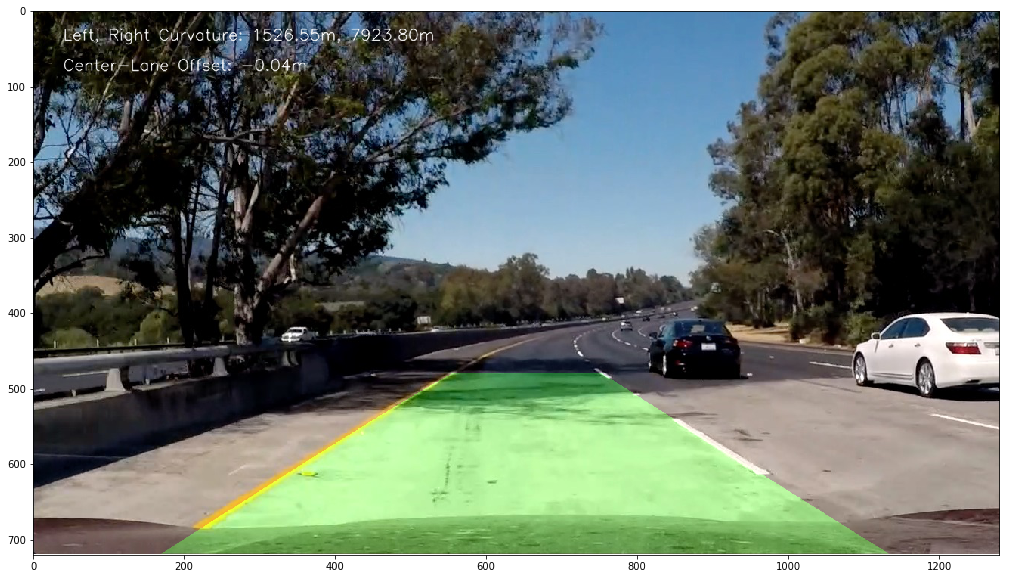

In [150]:
result = map_lane(img, binary_warped, ploty,left_fitx,right_fitx, Minv, left_curvature,right_curvature, offset )

fig, ax = plt.subplots(figsize=(20, 10))
ax.imshow(result)
plt.xlim(0, 1280)
plt.ylim(720, 0)

## Pipeline - put all together

In [158]:
def pipeline(img, sx_thresh=(20, 100), s_thresh=(170, 255)):
    #############################  Distortion Correctin  ##########################################
    # correct distortion using cameraMatrix and distortion_coefficient
    assert mtx is not None, 'Need to get camera calibration matrices first.'
    assert dist is not None, 'Need to get distortion coefficients first.'
    
    undistorted = cv2.undistort(img, mtx, dist, None, mtx)
    #############################  Threshold  ####################################################
    # Convert to HLS color space and separate the S channel and L channel
    hls = cv2.cvtColor(undistorted, cv2.COLOR_RGB2HLS) # has to add [.astype(np.float)], it shows dark image other then.
    l_channel = hls[:,:,1] 
    s_channel = hls[:,:,2]
    # Sobel x
    sobelx = cv2.Sobel(l_channel, cv2.CV_64F, 1, 0) # Take the derivative in x
    abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
    
    # Threshold x gradient
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= sx_thresh[0]) & (scaled_sobel <= sx_thresh[1])] = 1
    
    # Threshold color channel
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh[0]) & (s_channel <= s_thresh[1])] = 1
    
    # Combine   
    threshold = np.zeros_like(sxbinary)
    threshold[(sxbinary==1) | (s_binary==1)] = 1
    
    
    #############################  perspective transform  ######################################
    binary_warped, M, Minv = perspective_transform(threshold,src,dst)
    
    
    #############################  Finding the lane  ##########################################
    left_fit,right_fit,  ploty,left_fitx,right_fitx,  lefty,leftx,righty,rightx,  out_img = find_lane(binary_warped)
    
    
    ############################# Calculate the curvature #####################################
    ### input: lefty,leftx,righty,rightx, ploty
    left_curvature = calc_curvature(lefty, leftx, np.max(ploty))
    right_curvature = calc_curvature(righty, rightx, np.max(ploty))
    
    ############################# Calculate the Offset ######################################## 
    offset = calc_offset(left_fitx[-1],right_fitx[-1], img.shape[1]//2 )
    
    
    #############################  Mapping the lanes  #########################################
    result = map_lane(img, binary_warped, ploty,left_fitx,right_fitx, Minv, left_curvature,right_curvature, offset )

    # Return the resulting image and matrix
    return result 

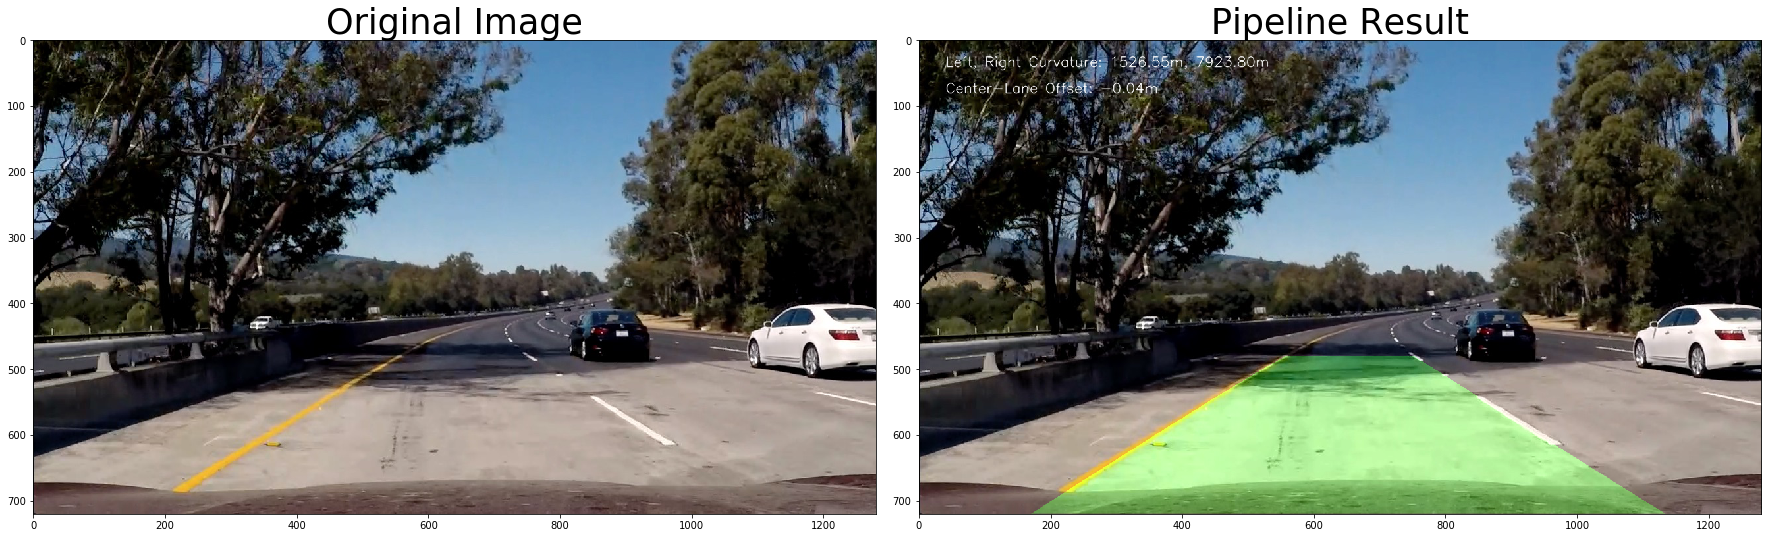

In [160]:
img = mpimg.imread('test_images/test5.jpg')
result = pipeline(img)
plot_img(img,result, 'Pipeline Result')

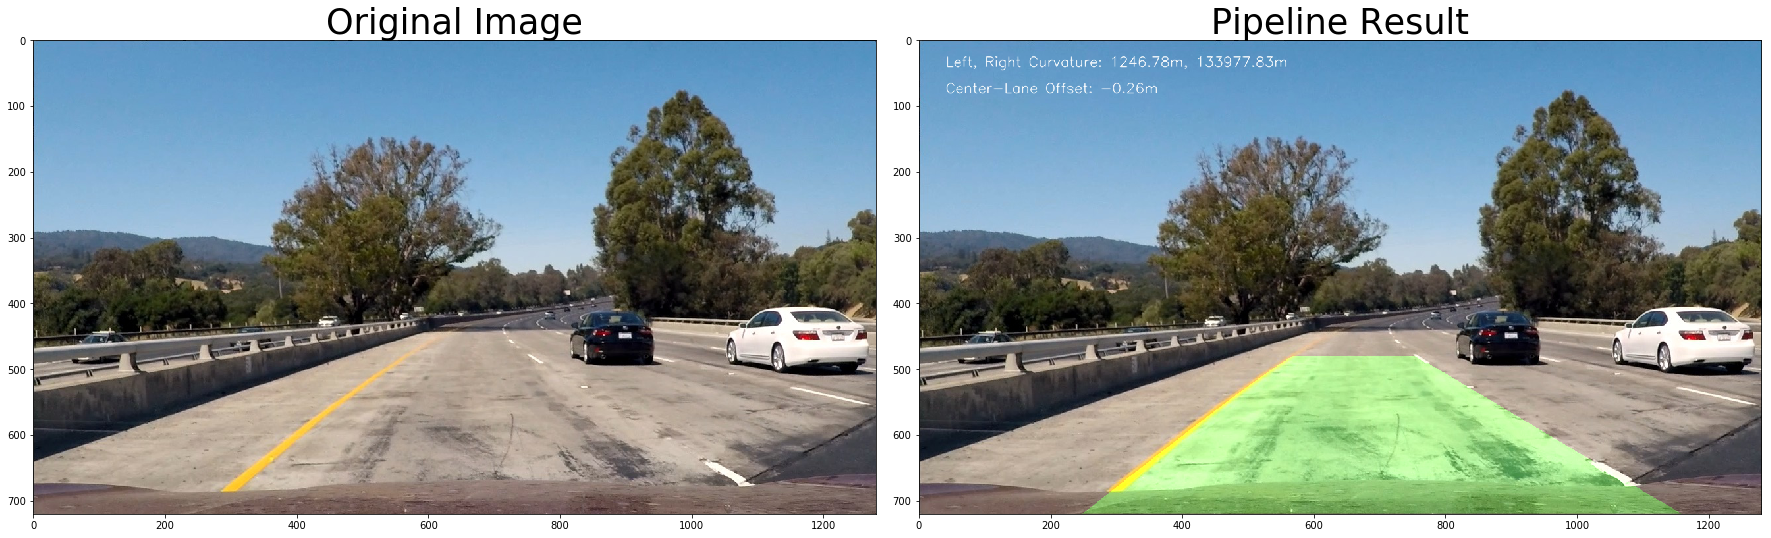

In [153]:
img = mpimg.imread('test_images/test1.jpg')
result = pipeline(img,mtx,dist)
plot_img(img,result, 'Pipeline Result')

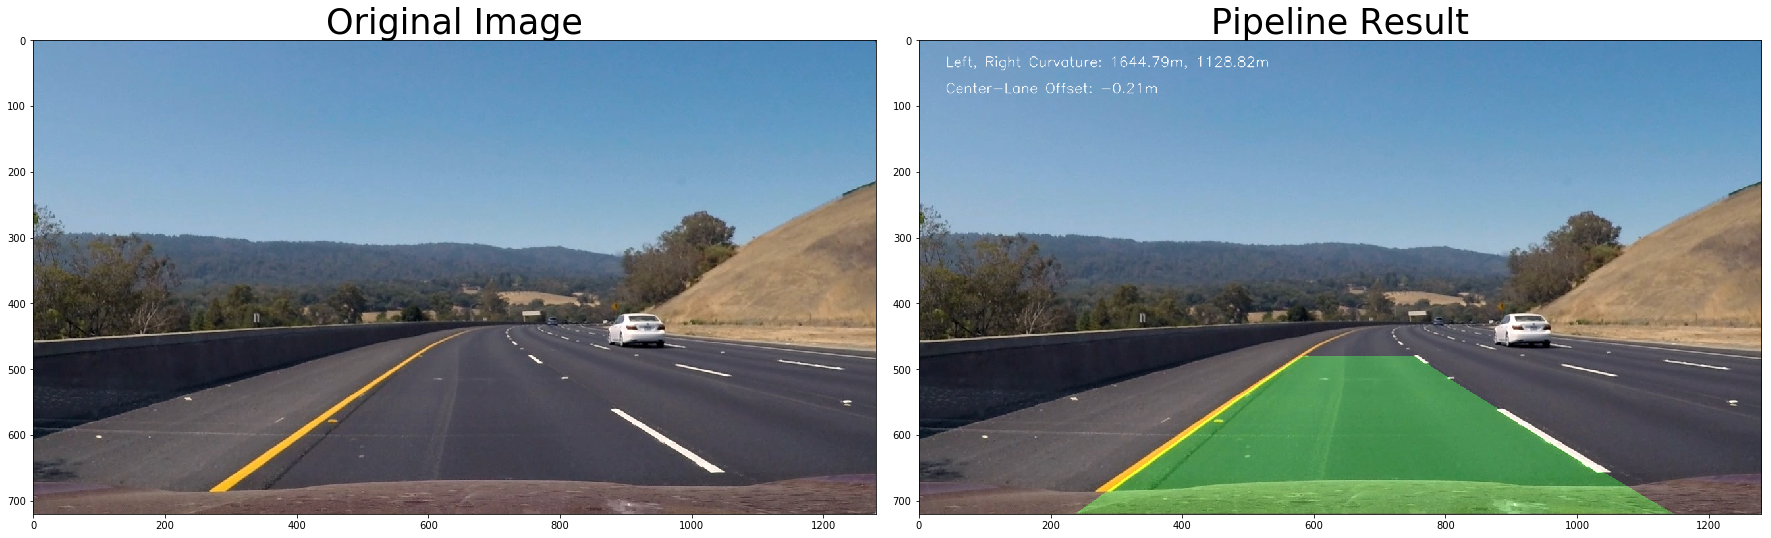

In [154]:
img = mpimg.imread('test_images/test3.jpg')
result = pipeline(img,mtx,dist)
plot_img(img,result, 'Pipeline Result')

## Test pipeline on a video

In [155]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [161]:
white_output = 'project_video_output.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
##clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)
clip1 = VideoFileClip("project_video.mp4")
white_clip = clip1.fl_image(pipeline) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video assets/project_video_lanes.mp4
[MoviePy] Writing video assets/project_video_lanes.mp4


100%|█████████████████████████████████████████████████████████████████████████████▉| 1260/1261 [02:39<00:00,  8.12it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: assets/project_video_lanes.mp4 

Wall time: 2min 40s


In [162]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))